# Table of contents<a name="top"></a>
1. [MLP - CrossEntropy](#mlp-ce)
2. [MLP - MeanSquaredError](#mlp-mse)
3. [CNN - CrossEntropy](#cnn-ce)
4. [CNN - MeanSquaredError](#cnn-mse)
9. [End](#end)

In [1]:
import os 
# work one level higher, RUN ONLY ONCE!
os.chdir('../')
import utils
print("moved up!", utils.get_now())

moved up! 250121-1112


In [2]:
from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [3]:
import typing as tp
from functools import partial

import jax
import jax.numpy as jnp
import jax.tree_util as tu
import jax.flatten_util as fu
import treex as tx
import tx_ohacc
import optax
import torch
import math

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import copy

import utils
import training
import lib_data
import modules
import callbacks
import plotting
import importlib

%env XLA_PYTHON_CLIENT_MEM_FRACTION=.9

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(jax.devices())

# set seed, define types
Batch = tp.Mapping[str, np.ndarray]
Model = tx.Sequential
Logs = tp.Dict[str, jnp.ndarray]

shade_colours = plt.get_cmap('Set3')
dark_colours = plt.get_cmap('tab10')
all_colours = plt.get_cmap('tab20')

def light_colours(i):
    return all_colours(2*i+1)

import matplotlib
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

2025-01-21 11:12:16.844179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.9
[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


## MLP  Cross Enropy<a name="mlp-ce"></a> 
[Back to top](#top)

In [4]:
import get_models
importlib.reload(get_models)
base_width = 8
n_out = 10
depth = 3
block_depth = 3
check_shape = False
modelfn_list = [
    lambda x: get_models.get_VGG(depth, block_depth, n_out, base_width, multiplier=2, 
                                 use_BN=True, use_DO=False, check_shape=check_shape), # VGG depth = 3]
]

loss_list = ['ce']
seed_list = [x for x in range(3)]
modelfn_ind_list = [0]
lr_list = [utils.signif(0.002 / (1.6 ** i), 3) for i in range(5)]
bs_list = [64, 256, 1024]
beta_list = [(0., 0., 0.), (0.9, 0., 0.), (0.0, 0.99, 0.), (0.0, 0.99, -1.), (0.0, 0.99, 1.), (0.9, 0.99, 0.),
             (0.9, 0.99, -1.), (0.9, 0.99, 1.)] # SGD, MoM, RMS, Adam

# # dry run
# seed_list = [0]
# lr_list = [0.002]
# bs_list = [60]
# beta_list = [(0., 0., 0.), (0.9, 0., 0.), (0.0, 0.99, 0.), (0.9, 0.99, 0.)]
# beta_list = [(0.0, 0.99, -1.), (0.0, 0.99, 1.), (0.9, 0.99, -1.), (0.9, 0.99, 1.)] # SGD, MoM, RMS, Adam

from train_scripts.cifar5k_adam_train import train_model
job = train_model

import itertools
s = [loss_list, modelfn_ind_list, seed_list, bs_list, lr_list, beta_list]
i_list = list(itertools.product(*s))
train_shuffle=True
print(len(i_list), "tasks")
last_loss = ''

360 tasks


In [ ]:
from tqdm import tqdm

In [9]:
importlib.reload(lib_data)
importlib.reload(callbacks)
importlib.reload(training)
importlib.reload(modules)
importlib.reload(tx_ohacc)

all_train_loss = []
all_valid_loss = []
all_valid_acc = []
all_train_acc = []
all_hess = []
all_evevals = []
all_eigvecs = []
all_eigvals = []
all_weights = []
all_gradients = []
compute_hessian = False
all_exp_names = []
all_lses = []
all_lrs = []

# for model_mode in ['vanilla', 'noDO', 'noBN', 'noDOnoBN']:
use_DO = False
use_BN = True
sc_conv = True # model A, like the paper
force_train = False
load_files = True

if load_files:
    i_bar = tqdm(i_list, total=len(i_list), miniters=10)
else:
    i_bar = i_list

for params in i_bar:

    loss, modelfn_ind, seed, bs, lr, betas = params
    b1, b2, b3 = betas

    if bs > 64 and b3 != 0.:
        if not load_files:
            print("skipping")
        continue
    
    if bs == 1024:
        sws = 250
        n_epochs = 50000
    elif bs == 256:
        sws = 50
        n_epochs = 12500
    elif bs == 64:
        sws = 10
        n_epochs = 3125
    elif bs > 50 and bs < 64:
        sws = 10
        n_epochs = 3125
    
    # ----------------------------------------------------------------------------
    import importlib
    # Experiment Settings 
    n_out = 10

    n_train: int = int(512*n_out)
    n_eval: int = int(200*n_out)
    n_hess: int = int(500*n_out)

#     n_epochs: int = 250000 # 
    num_eigvals: int = 10
    num_eigvecs: int = 0
#     bs: int = 1024 # n_train
    eval_bs: int = 1024
    hess_bs = 1024
    n_plots: int = n_epochs # double, can make this 60 for final experiments
    plot_freq: int = 1

    # n_out: int = 4 # n_classes
    classification: bool = True

    utils.set_seed(seed)
    import importlib
    importlib.reload(lib_data)
    
    if loss != last_loss:
        print(f"\n -----------------------------------------------------------------------------------\n")
        print("Getting new dataset \n")
        datasets = lib_data.get_cifar10(flatten=False, tr_indices=n_train, te_indices=n_eval, 
                                    tr_classes=n_out, te_classes=n_out, hess_indices=n_hess, 
                                    hess_classes=n_out, one_hot=True if loss == 'mse' else False, 
                                        augmentations=False, visualise=False)

        data_name = "cifar10_"+str(n_out)+"cl_"+str(n_train) + "_" + str(n_eval) 
        train_loader = lib_data.NumpyLoader(datasets[0], batch_size=bs)
        hess_loader = lib_data.NumpyLoader(datasets[2], batch_size=hess_bs)
        full_train_loader = lib_data.NumpyLoader(datasets[0], batch_size=n_train)
        val_loader = lib_data.NumpyLoader(datasets[1], batch_size=eval_bs)

        for inputs, targets in full_train_loader: break    
        for tr_inputs, tr_targets in train_loader: break
        for h_inputs, h_targets in hess_loader: break
        for val_inputs, val_targets in val_loader: break
        hessian_data = [(h_inputs, h_targets)]

        if loss == 'mse':
            class_labels, class_counts = np.unique(np.argmax(targets, axis=1), return_counts=True)
            _, class_counts_eval = np.unique(np.argmax(val_targets, axis=1), return_counts=True)
        else:
            class_labels, class_counts = np.unique(targets, return_counts=True)
            _, class_counts_eval = np.unique(val_targets, return_counts=True)

        print(f"classes {class_labels}; counts tr:{class_counts}, ev:{class_counts_eval}")
        last_loss = loss

# ----------------------------------------------------------------------------
#     lr, sw, neps = utils.cifar5k_lr_fix(lr)
#     lr = utils.signif(lr)
#     n_epochs = 10000
#     sw = 1000
#     if load_files:
#         i_bar.set_description("")

    if not load_files:
        print(f"\n -----------------------------------------------------------------------------------\n")
        print(f"params; lr:{lr}, bs:{bs}, n_epochs:{n_epochs}, plot_freq:{plot_freq}, seed:{seed},")
    # get loss
    torch.manual_seed(seed)
    model, model_name = modelfn_list[modelfn_ind](0)
    model_name += "_seed"+str(seed)

    train_loader = lib_data.NumpyLoader(datasets[0], batch_size=bs, shuffle=train_shuffle, num_workers=0)
    val_loader = lib_data.NumpyLoader(datasets[1], batch_size=eval_bs, num_workers=0)
    dataloaders = [train_loader, val_loader]

    for tr_inputs, tr_targets in train_loader: break
    for val_inputs, val_targets in val_loader: break

    # build model - MLP with set net depth
    # treex only takes dim-out in layer construction

#     loss_fn = tx.losses.Crossentropy()
    loss_fn = tx.losses.MeanSquaredError() if loss == 'mse' else tx.losses.Crossentropy()
    loss_logs = tx.LossAndLogs(
        losses=loss_fn,
        metrics = tx_ohacc.Accuracy() if loss == 'mse' else tx.metrics.Accuracy(),
#         metrics=tx.metrics.Accuracy(),
    )

    warmup_steps = 2

    warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                            transition_steps=warmup_steps,
                                            transition_begin=0,)
    constant_scheduler = optax.constant_schedule(lr)

    # no cooling
    lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])

    
    # get optimizer
#     optimizer = tx.Optimizer(optax.sgd(lr_scheduler))
    optimizer = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
    optim_name = "sgd_family_b1_" + str(b1) + "_b2_" + str(b2) + "_b3_" + str(b3) + "_lr" \
            + str(lr) + "_epochs" + str(n_epochs) + "_warmup" + str(warmup_steps) + "_bs" + str(bs) + "_" + str(loss)

    if not load_files:
        print("X shapes", tr_inputs.shape, val_inputs.shape)
    cbs = [callbacks.saveWeightsCB(sws, grad=True)] # save every 10 epochs, 1MB per save, so should be < 1GB

    cbs.append(callbacks.thinCB(plot_freq=plot_freq))
    esCB = callbacks.earlyStopCB(acc_threshold=0.99, cbs=None, min_eps=sws, max_eps=n_epochs, verbose=False,
                                 low_eps=max(sws, 100), low_thresh=0.11)
    cbs.append(esCB)
    cb_name_str = utils.get_callback_name(cbs)
    cb_name_list = utils.get_callback_name_list(cbs)

    # finalise model name
    experiment_name = utils.get_now() + "_" + data_name + "_" + model_name + "_" + optim_name
    
    try:
        if force_train:
            raise FileNotFoundError
        exp_name_load, lse = utils.find_latest_exp(experiment_name, n_epochs, save_freq=plot_freq, 
                                                   cbs=cb_name_list, unknown_lse=True)
#         print("Loaded", experiment_name)

    except FileNotFoundError:
    #     model = get_model(model_type)
        model, optimizer = training.init_step(model, optimizer, seed=int(seed), inputs=tr_inputs)
        num_params = utils.get_num_params(model)
        print("num params", num_params)
        history_train, history_test = training.train_model(model, optimizer, loss_logs, n_epochs, dataloaders, \
                                                   experiment_name, cbs, [], force_fb=False, tqdm_over_epochs=True)            

    exp_name_load, lse = utils.find_latest_exp(experiment_name, n_epochs, save_freq=plot_freq, cbs=cb_name_list, 
                                               unknown_lse=True)
    all_exp_names.append(exp_name_load)
    all_lses.append(lse)
    if not load_files:
        print("Loaded", exp_name_load, "LSE", lse)

    hist_train_load = utils.load_thing("traj/" + exp_name_load + "/hist_train_thin" + str(lse) + ".pkl")
    hist_test_load = utils.load_thing("traj/" + exp_name_load + "/hist_test_thin" + str(lse) + ".pkl")

    train_loss = [d['loss'] for d in hist_train_load]
    valid_loss = [d['loss'] for d in hist_test_load]
    all_valid_loss.append(valid_loss)
    all_train_loss.append(train_loss)

    train_acc = [d['accuracy'] for d in hist_train_load]
    valid_acc = [d['accuracy'] for d in hist_test_load]
    all_valid_acc.append(valid_acc)
    all_train_acc.append(train_acc)
    if not load_files:
        print(f"final accs, {train_acc[-2]*100:.2f}, {valid_acc[-1]*100:.2f}, lse {lse}")
        print(f" max  accs, {np.max(np.array(train_acc))*100:.2f}, {np.max(np.array(valid_acc))*100:.2f}, lse {lse}")
        print(f"final loss, {train_loss[-2]:.2f}, {valid_loss[-1]:.2f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [01:02<00:00,  5.75it/s]


In [10]:
print("done")

done


In [12]:
print(len(all_valid_acc), len(i_list))
from tabulate import tabulate

240 360


In [13]:
# EFFECT of increasing batch sizeon LSE
# 4 dims, Seed, LR, BS, and learning alg
# Meta grouping Learning Alg (iter), Seed (iter), BS(Row), LR(Col)
# use lots of tables, each table showing 

headers = lr_list
bs_breaks = [0, 40, 60]
LA_NAMES = ['SGD', 'MOM', 'RMS', 'ADAM']

for i_la in range(4): # learn alg
    print("------------------------------------------------------------------")
    print(LA_NAMES[i_la])
    for i_seed in range(3): # seed
        print("Seed", i_seed)
        table_contents = []
        for i_bs in range(3): # bs
            this_row = []
            if i_la < 3:
                ind_la = i_la
            else:
                ind_la == 5 if i_bs == 0 else 3
            
            ind_bs = bs_breaks[i_bs]
            gap_lr = 4 if i_bs > 0 else 8
            for i_lr in range(5): # lr
                ind = i_seed*80 + ind_bs + i_lr*gap_lr + ind_la
                if ind > 240:
                    print(i_seed, i_bs, i_lr, i_la)
                    print(ind_bs, gap_lr, ind_la)
                this_row.append(all_lses[ind])
#                 print(ind)
            table_contents.append(this_row)
        table = tabulate(np.array(table_contents), headers, tablefmt="fancy_grid")
        print(table)


# 
#     print(all_valid_acc[i][-1])

------------------------------------------------------------------
SGD
Seed 0
╒═════════╤═══════════╤════════════╤════════════╤════════════╕
│   0.002 │   0.00125 │   0.000781 │   0.000488 │   0.000305 │
╞═════════╪═══════════╪════════════╪════════════╪════════════╡
│     147 │       282 │        468 │        704 │       1133 │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│     520 │       802 │       1271 │       2054 │       3239 │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│    2136 │      3421 │       5560 │       8824 │      13918 │
╘═════════╧═══════════╧════════════╧════════════╧════════════╛
Seed 1
╒═════════╤═══════════╤════════════╤════════════╤════════════╕
│   0.002 │   0.00125 │   0.000781 │   0.000488 │   0.000305 │
╞═════════╪═══════════╪════════════╪════════════╪════════════╡
│     243 │       376 │        530 │        794 │       1300 │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│     588 │       909 │       147

In [23]:
# EFFECT of increasing batch size, which should decrease learning temperature
# 4 dims, Seed, LR, BS, and learning alg
# Meta grouping Learning Alg (iter), Seed (iter), BS(Row), LR(Col)
# use lots of tables, each table showing 

headers = lr_list
bs_breaks = [0, 40, 60]
LA_NAMES = ['SGD', 'MOM', 'RMS', 'ADAM']

for i_la in range(4): # learn alg
    print("------------------------------------------------------------------")
    print(LA_NAMES[i_la])
    for i_seed in range(3): # seed
        print("Seed", i_seed)
        table_contents = []
        for i_bs in range(3): # bs
            this_val_accs = []
            ind_la = i_la
            if i_bs == 0 and ind_la == 3:
                ind_la = 5
            ind_bs = bs_breaks[i_bs]
            gap_lr = 4 if i_bs > 0 else 8
            for i_lr in range(5): # lr
                ind = i_seed*80 + ind_bs + i_lr*gap_lr + ind_la
                ind_tr_max = np.argmax(all_train_acc[ind])
                this_val_accs.append(all_valid_acc[ind][ind_tr_max]*100) # used to be -1
#                 print(ind)
            table_contents.append(this_val_accs)
        table = tabulate(np.array(table_contents), headers, tablefmt="fancy_grid")
        print(table)


# 
#     print(all_valid_acc[i][-1])

------------------------------------------------------------------
SGD
Seed 0
╒═════════╤═══════════╤════════════╤════════════╤════════════╕
│   0.002 │   0.00125 │   0.000781 │   0.000488 │   0.000305 │
╞═════════╪═══════════╪════════════╪════════════╪════════════╡
│ 39.7004 │   30.2059 │    29.1305 │    29.3938 │    28.966  │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│ 27.6492 │   26.6621 │    27.2266 │    27.7887 │    24.5117 │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│ 31.6238 │   30.9047 │    31.3477 │    30.8309 │    30.857  │
╘═════════╧═══════════╧════════════╧════════════╧════════════╛
Seed 1
╒═════════╤═══════════╤════════════╤════════════╤════════════╕
│   0.002 │   0.00125 │   0.000781 │   0.000488 │   0.000305 │
╞═════════╪═══════════╪════════════╪════════════╪════════════╡
│ 34.284  │   28.2363 │    28.109  │    33.1516 │    32.4074 │
├─────────┼───────────┼────────────┼────────────┼────────────┤
│ 31.7668 │   30.0438 │    30.633

In [19]:
for i in range(len(all_valid_acc)):
    if i % 10 == 0:
        print(f"------{i}-----")
    print(f"{all_valid_acc[i][-1]*100:.2f}")

------0-----
38.76
38.86
52.79
44.25
31.79
51.14
39.28
29.22
30.38
29.53
------10-----
41.52
43.11
30.53
43.00
40.49
29.74
29.84
29.71
38.38
38.29
------20-----
27.79
38.41
40.14
29.48
29.30
29.44
33.59
35.44
28.81
35.62
------30-----
36.06
30.68
29.34
30.47
33.81
30.78
28.59
32.15
33.39
35.20
------40-----
27.92
29.09
41.37
38.98
27.45
28.30
33.72
34.05
27.28
28.56
------50-----
31.81
30.13
28.16
25.71
29.08
26.78
24.51
26.88
29.47
29.12
------60-----
31.75
33.92
39.23
38.32
30.86
31.65
34.34
33.89
31.13
31.82
------70-----
31.81
34.17
31.00
30.21
28.78
28.92
30.81
31.47
29.87
29.57
------80-----
34.04
30.90
46.38
39.61
33.37
51.75
13.07
29.54
28.98
32.09
------90-----
39.41
43.58
32.55
45.97
39.39
30.06
29.00
30.74
42.09
41.83
------100-----
31.77
42.78
40.83
30.01
33.01
32.31
42.21
37.30
29.94
36.36
------110-----
44.02
31.86
32.68
32.36
32.55
34.19
31.65
34.43
34.61
30.97
------120-----
31.47
30.53
37.99
31.91
30.04
29.38
37.52
38.01
30.73
28.56
------130-----
31.91
32.19
30.86
29.

In [24]:
# EFFECT of increasing LA on results
# 4 dims, Seed, BS, LR, and learning alg
# Meta grouping Seed (iter), BS(Iter), LR(Row), LA(Col)
# use lots of tables, each table showing 
inds = []
LA_NAMES = ['SGD', 'MOM', 'RMS', 'ADAM']
headers = LA_NAMES
bs_breaks = [0, 40, 60]
BS_NAMES = [64, 256, 1024]

for i_seed in range(3): # seed
    print("------------------------------------------------------------------")
    print("Seed", i_seed)
    for i_bs in range(3): # bs
        print("BS", BS_NAMES[i_bs])
        table_contents = []
        ind_bs = bs_breaks[i_bs]
        gap_lr = 4 if i_bs > 0 else 8    
        for i_lr in range(5): # lr
            this_val_accs = []
            for i_la in range(4): # lr
                ind_la = i_la
                if i_bs == 0 and ind_la == 3:
                    ind_la = 5
            
                ind = i_seed*80 + ind_bs + i_lr*gap_lr + ind_la
                inds.append(ind)
#                 ind_tr_max = np.argmax(all_train_acc[ind])
                ind_tr_max = -1
                this_val_accs.append(all_valid_acc[ind][ind_tr_max]*100) # used to be -1
#                 print(ind)
            table_contents.append(this_val_accs)
        table = tabulate(np.array(table_contents), headers, tablefmt="fancy_grid")
        print(table)


# 
#     print(all_valid_acc[i][-1])

------------------------------------------------------------------
Seed 0
BS 64
╒═════════╤═════════╤═════════╤═════════╕
│     SGD │     MOM │     RMS │    ADAM │
╞═════════╪═════════╪═════════╪═════════╡
│ 38.7621 │ 38.8621 │ 52.7863 │ 51.1406 │
├─────────┼─────────┼─────────┼─────────┤
│ 30.3809 │ 29.527  │ 41.5223 │ 43      │
├─────────┼─────────┼─────────┼─────────┤
│ 29.8449 │ 29.7105 │ 38.3801 │ 38.4086 │
├─────────┼─────────┼─────────┼─────────┤
│ 29.2961 │ 29.4449 │ 33.591  │ 35.6164 │
├─────────┼─────────┼─────────┼─────────┤
│ 29.3375 │ 30.4699 │ 33.8102 │ 32.1465 │
╘═════════╧═════════╧═════════╧═════════╛
BS 256
╒═════════╤═════════╤═════════╤═════════╕
│     SGD │     MOM │     RMS │    ADAM │
╞═════════╪═════════╪═════════╪═════════╡
│ 27.9219 │ 29.0875 │ 41.3711 │ 38.9777 │
├─────────┼─────────┼─────────┼─────────┤
│ 27.4516 │ 28.2957 │ 33.723  │ 34.0516 │
├─────────┼─────────┼─────────┼─────────┤
│ 27.2777 │ 28.5566 │ 31.8109 │ 30.1332 │
├─────────┼─────────┼─────────┼

In [20]:
# EFFECT OF UB and LB on RMS/Adam, using BS64
for k in range(3):
    
    headers = ['SGD', 'Mom', 'rms', 'rms-UB', 'rms-LB', 'adam', 'adam-UB', 'adam-LB']
    from tabulate import tabulate
    table_contents = []
    for j in range(5):
        this_val_accs = []
    #     out = ""
        for i in range(8):
            ind = k*80+8*j+i
#             ind_tr_max = np.argmax(all_train_acc[ind])
            ind_tr_max = -1
            this_val_accs.append(all_valid_acc[ind][ind_tr_max]*100) # used to be -1
#             this_val_accs.append(all_valid_acc[ind][-1]*100)
    #     table = tabulate(np.array(this_val_accs)[np.newaxis, :], headers, tablefmt="fancy_grid")
    #     print(table)
        table_contents.append(this_val_accs)
    table = tabulate(np.array(table_contents), headers, tablefmt="fancy_grid")
    print(table)

# 
#     print(all_valid_acc[i][-1])

╒═════════╤═════════╤═════════╤══════════╤══════════╤═════════╤═══════════╤═══════════╕
│     SGD │     Mom │     rms │   rms-UB │   rms-LB │    adam │   adam-UB │   adam-LB │
╞═════════╪═════════╪═════════╪══════════╪══════════╪═════════╪═══════════╪═══════════╡
│ 38.7621 │ 38.8621 │ 52.7863 │  44.2539 │  31.7883 │ 51.1406 │   39.2754 │   29.2234 │
├─────────┼─────────┼─────────┼──────────┼──────────┼─────────┼───────────┼───────────┤
│ 30.3809 │ 29.527  │ 41.5223 │  43.1094 │  30.532  │ 43      │   40.4875 │   29.7391 │
├─────────┼─────────┼─────────┼──────────┼──────────┼─────────┼───────────┼───────────┤
│ 29.8449 │ 29.7105 │ 38.3801 │  38.2883 │  27.7887 │ 38.4086 │   40.1445 │   29.4805 │
├─────────┼─────────┼─────────┼──────────┼──────────┼─────────┼───────────┼───────────┤
│ 29.2961 │ 29.4449 │ 33.591  │  35.4449 │  28.8125 │ 35.6164 │   36.0559 │   30.6797 │
├─────────┼─────────┼─────────┼──────────┼──────────┼─────────┼───────────┼───────────┤
│ 29.3375 │ 30.4699 │ 33.8102 │ 

In [ ]:
# compute eigenvalues and eigenvectors 

0.1143789142370224


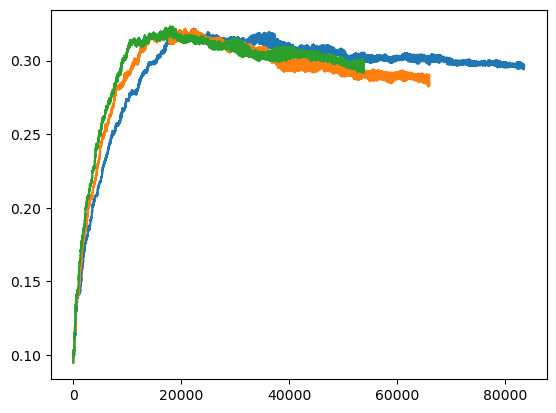

In [8]:
print(all_valid_acc[1][300])
plt.plot(all_valid_acc[0])
plt.plot(all_valid_acc[1])
plt.plot(all_valid_acc[2])

In [9]:
print(len(all_valid_acc))

160


In [10]:
sub_lrs = [0.001]
acc_thresh = []
skip_subs = False
n_sublr = len(sub_lrs)
n_seed = len(seed_list)
n_at = len(acc_thresh)
n_lr = len(all_lrs[0])
n_mc = n_lr -1

In [11]:
# compute all eigenvalues and eigenvectors at the checkpoints of each base model, and ends of all models (base and sub)
# outputs: eigvals, eigvecs [sublrs, seeds, mcs, thresh_starts+thresh_ends+base_end]
# plot differences
import time
model, _ = modelfn(0)
model, optimizer = training.init_step(model, optimizer, seed=int(seed), inputs=tr_inputs)
num_params = utils.get_num_params(model)
print("num params", num_params)

t_hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=(datasets[2].data[:n_hess], datasets[2].targets[:n_hess]), 
                        save_freq=10, hess_bs=hess_bs, model=model)
t_specCB = callbacks.spectrumCB(n_eigs=20, n_evecs=10, 
                loss_fn=loss_fn, seed=seed, hvpCB=t_hvpCB, save_freq=10, verbose=False)

rec_n_eigvals = 20
rec_n_eigvecs = 10
rec_eigvals = np.zeros((n_seed, n_mc, rec_n_eigvals))# recompute
rec_eigvecs = np.zeros((n_seed, n_mc, rec_n_eigvecs, num_params))# recompute
eigval_override = False
m_override = False
s_override = False
load_eigvecs = False
n_eigvals_comp = 2

counter = 0
start_time = time.time()
all_sims = []
total_n = n_sublr*n_seed*n_mc*(2*n_at+1)
print("total_N", total_n)
last_eigvecs = []
eos_stat = np.zeros((n_seed, n_mc))

for i_seed in range(n_seed):
    for i_mc in range(n_mc):
        mc = i_mc + i_seed*n_lr
        t_exp_name = all_exp_names[mc]
        t_lse = all_lses[mc]
        m_lse = int(np.around((t_lse+1)//2/sws[i_mc], 0)*sws[i_mc])
        s_lse = int(sws[i_mc])
#         print(t_lse, m_lse)
#         continue
#         input()
        skip_compute_t = False
        skip_compute_m = False
        skip_compute_s = False
        
        if not eigval_override:
            try:
                t_eigvals = utils.load_thing("traj/" + t_exp_name + f"/eigvals_{t_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                t_eigvecs = utils.load_thing("traj/" + t_exp_name + f"/eigvecs_{t_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                skip_compute_t = True

            except FileNotFoundError:
                skip_compute_t = False

        if not skip_compute_t:
            t_model0 = utils.load_weights_nn(model.copy(), "traj/"+t_exp_name+"/w"+str(t_lse)+".pkl")
            t_specCB.forward(epoch=10, model=t_model0)
            t_eigvals = t_specCB.last_eigval.copy()
            utils.save_thing(t_eigvals, "traj/" + t_exp_name + f"/eigvals_{t_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
            t_eigvecs = t_specCB.last_eigvec.copy()
            utils.save_thing(t_eigvecs, "traj/" + t_exp_name + f"/eigvecs_{t_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
        
        if not m_override:
            try:
                m_eigvals = utils.load_thing("traj/" + t_exp_name + f"/eigvals_{m_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                m_eigvecs = utils.load_thing("traj/" + t_exp_name + f"/eigvecs_{m_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                skip_compute_m = True

            except FileNotFoundError:
                skip_compute_m = False
        
        if not skip_compute_m:
            m_model0 = utils.load_weights_nn(model.copy(), "traj/"+t_exp_name+"/w"+str(m_lse)+".pkl")
            t_specCB.forward(epoch=10, model=m_model0)
            m_eigvals = t_specCB.last_eigval.copy()
            utils.save_thing(m_eigvals, "traj/" + t_exp_name + f"/eigvals_{m_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
            m_eigvecs = t_specCB.last_eigvec.copy()
            utils.save_thing(m_eigvecs, "traj/" + t_exp_name + f"/eigvecs_{m_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
        
        if not s_override:
            try:
                s_eigvals = utils.load_thing("traj/" + t_exp_name + f"/eigvals_{s_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                s_eigvecs = utils.load_thing("traj/" + t_exp_name + f"/eigvecs_{s_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
                skip_compute_s = True

            except FileNotFoundError:
                skip_compute_s = False
        
        if not skip_compute_m:
            s_model0 = utils.load_weights_nn(model.copy(), "traj/"+t_exp_name+"/w"+str(s_lse)+".pkl")
            t_specCB.forward(epoch=10, model=s_model0)
            s_eigvals = t_specCB.last_eigval.copy()
            utils.save_thing(s_eigvals, "traj/" + t_exp_name + f"/eigvals_{s_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")
            s_eigvecs = t_specCB.last_eigvec.copy()
            utils.save_thing(s_eigvecs, "traj/" + t_exp_name + f"/eigvecs_{s_lse}_{rec_n_eigvals}_{rec_n_eigvecs}.pkl")

        
        rec_eigvals[i_seed, i_mc] = t_eigvals
        if load_eigvecs:
            rec_eigvecs[i_seed, i_mc] = t_eigvecs
        out = f"{all_lrs[0][i_mc]}: MM"
        for n_eigvals_comp in range(1, 5):
#             try:
            out += f"{utils.dk_cos(m_eigvecs[:n_eigvals_comp].T, t_eigvecs[:n_eigvals_comp].T)*100:.2f}|"
#             except AssertionError:
#                 print(m_eigvecs.shape, t_eigvecs.shape, t_model)
#                 raise AssertionError
        out += ", SS"
        ss_nums = []
        for n_eigvals_comp in range(1, 5):
            ss_stat = utils.dk_cos(s_eigvecs[:n_eigvals_comp].T, t_eigvecs[:n_eigvals_comp].T)
            out += f"{ss_stat*100:.2f}|"
            ss_nums.append(ss_stat)
        
        print(out)
        eos_stat[i_seed, i_mc] = max(ss_nums)
#         if len(last_eigvecs) == 0:
#             last_eigvecs = t_eigvecs[:n_eigvals_comp]
#         else:
#             if len(t_eigvecs[0]) == len(last_eigvecs[0]):
#                 print(all_lrs[0][i_mc], utils.dk_cos(t_eigvecs[:n_eigvals_comp].T, last_eigvecs[:n_eigvals_comp].T))
#                 last_eigvecs = t_eigvecs[:n_eigvals_comp].copy()
#             else:
#                 print("param count error")
#                 last_eigvecs = t_eigvecs[:n_eigvals_comp].copy()
        counter += 1
        if i_mc == 0 and i_seed == 0:
            print(f"t_ave={(time.time()-start_time)/counter:.1f}, n={counter}, lambda={t_eigvals[0]:.1f}")
    
    print(f"t_ave={(time.time()-start_time)/counter:.1f}, n={counter}, lambda={t_eigvals[0]:.1f}")
print("total_time", time.time()-start_time)

num params 47482
total_N 155
0.0002: MM99.23|99.27|99.00|85.51|, SS98.18|98.32|97.51|94.43|
t_ave=1.5, n=1, lambda=1226.8
0.00025: MM98.92|99.05|98.93|86.10|, SS98.12|98.36|97.79|93.94|
0.0003: MM99.30|99.32|99.13|80.78|, SS98.54|98.64|98.05|97.43|
0.00035: MM99.08|99.01|61.69|92.71|, SS98.70|98.68|61.13|87.70|
0.0004: MM99.62|99.75|99.79|79.43|, SS99.62|99.75|99.79|79.43|
0.00045: MM97.81|98.39|98.58|85.26|, SS98.09|98.35|98.05|86.24|
0.0005: MM97.99|98.48|98.52|80.01|, SS94.73|95.60|62.89|89.24|
0.000625: MM96.85|97.84|98.30|81.27|, SS96.05|96.46|95.13|90.88|
0.00075: MM98.17|98.52|98.46|80.96|, SS96.32|96.60|61.31|90.08|
0.000875: MM97.99|98.57|98.41|87.85|, SS61.66|57.11|64.22|62.77|
0.001: MM93.15|95.48|96.70|87.11|, SS64.61|65.46|68.31|68.04|
0.00125: MM94.92|97.20|62.15|97.53|, SS9.01|12.12|12.87|19.48|
0.0015: MM93.87|95.90|96.90|96.93|, SS84.52|84.55|81.55|79.01|
0.002: MM40.97|67.79|67.89|75.38|, SS6.40|6.58|16.79|23.10|
0.0032: MM6.61|42.83|93.31|83.62|, SS8.22|6.50|22.59|21

0.021: MM5.21|39.17|26.76|44.56|, SS55.93|44.80|55.09|49.47|
0.0336: MM3.34|8.87|7.68|16.99|, SS19.43|17.55|29.66|44.81|
0.0537: MM42.52|22.90|35.83|40.05|, SS7.68|29.03|27.93|40.24|
0.0859: MM57.73|52.00|56.22|53.48|, SS37.74|37.22|34.64|45.96|
0.137: MM17.77|32.83|31.26|43.88|, SS30.66|26.03|24.23|33.93|
0.22: MM59.85|37.90|36.08|35.49|, SS32.05|33.33|39.62|40.38|
0.352: MM8.03|36.39|46.31|48.45|, SS13.57|22.46|28.54|29.46|
0.563: MM6.14|37.35|33.54|36.96|, SS4.09|15.77|12.38|11.59|
0.901: MM32.48|21.91|18.04|18.22|, SS9.12|6.09|9.19|13.14|
1.44: MM5.92|14.61|15.08|16.30|, SS2.45|7.93|9.16|9.72|
2.31: MM3.08|14.46|19.65|23.42|, SS4.67|6.86|7.71|11.15|
3.69: MM0.54|8.09|11.35|14.39|, SS1.10|2.35|2.71|3.20|
5.9: MM0.61|10.30|14.26|11.92|, SS2.89|2.43|3.47|5.65|
t_ave=0.0, n=155, lambda=1.2
total_time 3.2123947143554688


In [12]:
print("Done")

Done


In [13]:
print(sws)

[10000, 10000, 10000, 10000, 10000, 10000, 1000, 1000, 1000, 100, 100, 10, 100, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [20]:
# eos_thresh = 0.000875
print(all_lrs[0])
eos_thresh = 0.00125

[0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005, 0.000625, 0.00075, 0.000875, 0.001, 0.00125, 0.0015, 0.002, 0.0032, 0.00512, 0.00819, 0.0131, 0.021, 0.0336, 0.0537, 0.0859, 0.137, 0.22, 0.352, 0.563, 0.901, 1.44, 2.31, 3.69, 5.9, 9.44]


In [16]:
# corr of submodels, eliminate over models

# print(np.array(sub_valid_acc).shape)
k_at = 0
k_gap = 1
# print(sim_results[:, :, :, :, 0].flatten().shape)
v_accs = []
flat_lrs = []
flat_lr_inds = []
flat_sharps = []
for i_seed in range(n_seed):
    for i_mc in range(n_mc):
        mc = i_seed*n_lr + i_mc
        v_accs.append(all_valid_acc[mc][-1]) 
        flat_lrs.append(all_lrs[0][i_mc])
        flat_lr_inds.append(i_mc)
        flat_sharps.append(rec_eigvals[i_seed, i_mc, 0])


In [17]:
eos_flag = (eos_stat > 0.7).flatten()

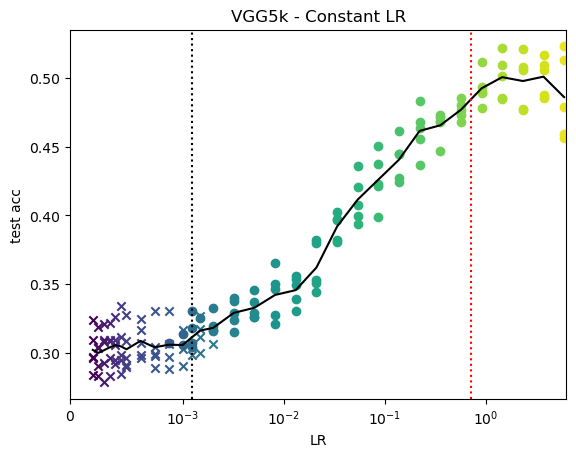

In [27]:
# 3. 3D - phases
#	For all models, get baseline eigvecs (using lr = 0.002), and get final eigvecs at specified accuracy. Compare rotations
#	Using rotation information, make 3D plot of sharpness, rotations, and accuracy

#2. Final sharpness - Time Plots (that they gradually flatten), initial sharpness - time plots
#	For all models, get initial and final sharpness, plot against time
fig, ax = plt.subplots(1, 1)
cmap = matplotlib.cm.get_cmap('viridis')
c_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_mc)
baseline_eigvec = []
# ax.scatter(np.log(flat_sharps), flat_sims, v_accs, color=[cmap(c_norm(x)) for x in flat_lr_inds], alpha=1.)

# markers = ['o' if all_lrs[0][x] > eos_thresh else 'x' for x in flat_lr_inds]
markers = ['x' if x else 'o' for x in eos_flag]

colors = [cmap(c_norm(x)) for x in flat_lr_inds]
for i in range(len(flat_sharps)):
    ax.scatter(all_lrs[0][flat_lr_inds[i]], v_accs[i], color=colors[i], alpha=1., marker=markers[i])

mean_line = np.mean(np.array(v_accs).reshape((n_seed, n_mc)), axis=0)
std = np.std(np.array(v_accs).reshape((n_seed, n_mc)), axis=0)
upper_line = mean_line + std
lower_line = mean_line - std
ax.plot(all_lrs[0][:-1], mean_line, c='k')
# ax.fill_between(all_lrs[0][:-1], lower_line, upper_line, color='k', alpha=0.2)

ax.set_xlabel('LR')
ax.axvline(x=eos_thresh, c='k', linestyle='dotted')
ax.axvline(x=0.901/1.6**0.5, c='r', linestyle='dotted')

ax.set_xscale('symlog', linthresh=0.001)
xlims = ax.get_xlim()
ax.set_xlim(0, xlims[1])
# ax.set_ylabel('sim')
ax.set_ylabel('test acc')
plt.title("VGG5k - Constant LR")
# plt.legend() 
plt.show()


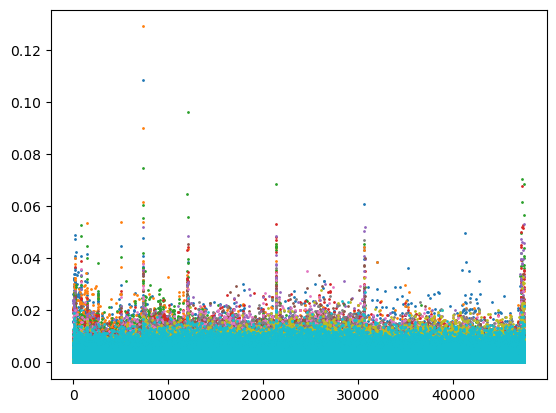

In [66]:
for i in range(10):
    plt.scatter(range(t_eigvecs.shape[1]), np.abs(t_eigvecs[i]).T, s=1)


## End <a name="end"></a> 
[Back to top](#top)